# Quick-start
In this tutorial we will show 
  * How to initialise the emulator.
  * How to obtain multipoles for the standard $\Lambda$CDM cosmology.

Let’s first import `comet` as well as other required libraries:

In [1]:
from comet import comet
import numpy as np
import matplotlib.pyplot as plt

At initialisation we only need to specify the perturbation theory model that we want to use (valid specifiers are currently either `"EFT"` or `"RS"`; for an overview of the models implemented in COMET, see here) and we can configure COMET either in $\mathrm{Mpc}$ units (`use_Mpc = True`, which is the default option) or in $h^{-1}\mathrm{Mpc}$ units (`use_Mpc = False`). All quantities that are not dimensionless are then returned or assumed to be given in the respective unit system. Let’s define an emulator object for the EFT model using the standard $h^{-1}\mathrm{Mpc}$ units:

In [2]:
EFT=comet(model="EFT", use_Mpc=False)

In order to make predictions for a given cosmological model we first need to specify the fiducial background cosmology, from which the Alcock-Paczynski distortions will be computed. This is done by calling the function `define_fiducial_cosmology` with a dictionary specifying the cosmological parameters and the redshift:

In [3]:
params_fid = {'h':0.695, 'wc':0.11544, 'wb':0.0222191, 'z':0.57}

# This assumes by default a "lambda" cosmology with w0 = -1, for other
# options, see the in-depth examples below.
EFT.define_fiducial_cosmology(params_fid=params_fid)

The function `Pell`, which returns the power spectrum multipoles takes generally three parameters:

1. The scales for which to compute the multipoles (in the corresponding units)
2. A parameter dictionary, specifying cosmological, bias, and (if applicable) additional redshift-space distortions parameters
3. The multipole number, i.e. ell = 0, 2, 4, or a list of multipole numbers

The parameter dictionary must include all shape parameters: the physical cold dark matter and baryon densities (`wc` and `wb`) and the scalar spectral index (`ns`). In case of a flat $\Lambda$CDM model we also need to specify values for $h$ (`h`), the amplitude of scalar fluctuations (`As`) and redshift (`z`). For other cosmologies, see In-depth options for obtaining multipoles.

In [4]:
# Let's create a parameter dictionary
params = {}

# We always need to specify the shape parameter values, e.g.
params['wc'] = 0.11544
params['wb'] = 0.0222191
params['ns'] = 0.9632

# For a LCDM cosmology, we also need:
params['h']  = 0.8
params['As'] = 2.3
params['z']  = 0.6

Finally, we define the values of the bias parameters. The complete list of parameters along with a brief explanation and their dictionary keywords can be found here. In the following we only specify values for the linear and quadratic bias, all other parameters are automatically set to zero:

In [5]:
params['b1'] = 2.
params['b2'] = -0.5

Now, let’s compute the monopole (`ell=0`), quadrupole (`ell=2`) and hexadecapole (`ell=4`) for a range of scales from $0.001 h\,\mathrm{Mpc}^{−1}$ to $0.3h\,\mathrm{Mpc}^{−1}$:

In [6]:
k_hMpc = np.logspace(-3,np.log10(0.3),100)
Pell_LCDM = EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model='lambda')

The output of `Pell` is given in a dictionary format:

In [7]:
print(Pell_LCDM.keys())

dict_keys(['ell0', 'ell2', 'ell4'])


So we can access our results and plot them as follow.

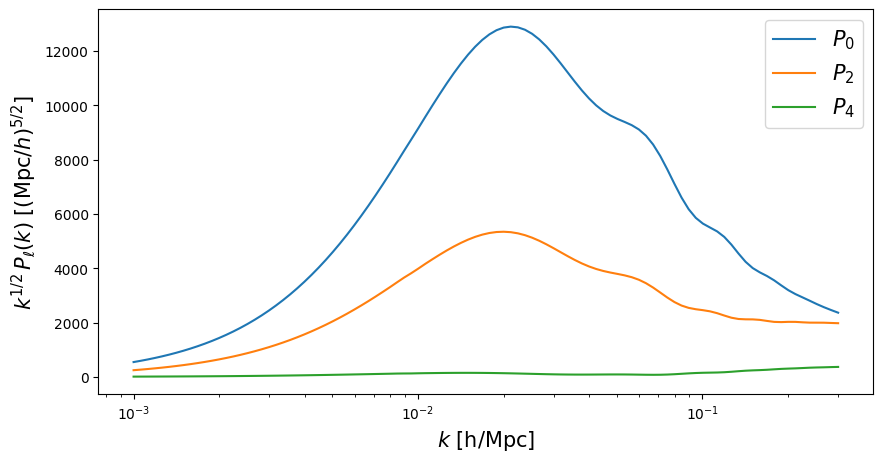

In [8]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell0"],c='C0',ls='-',label='$P_0$')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell2"],c='C1',ls='-',label='$P_2$')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell4"],c='C2',ls='-',label='$P_4$')
ax.set_xlabel('$k$ [h/Mpc]',fontsize=15)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{5/2}$]',fontsize=15)
ax.legend(fontsize=15)
plt.show()

# Exploring a few in-depth options

Let us now consider some of the more detailed options in 'COMET':
   * Specifying fiducial background cosmologies
   * Specifying Alcock-Paczynski parameters
   * Specifying the shot noise normalisation
   * Non-flat and non-$\Lambda$ cosmologies
   * Using the $f$-$\sigma_{12}$ parameter space
   * Options for providing different $k$-scales, float vs np.array vs list and the corresponding outputs
   * Description of the `fixed_cosmo_boost` function, i.e., speedup when just changing bias parameters
   * Using different bases for galaxy bias

## Fiducial background cosmologies

Above, we specified the fiducial background cosmology by setting the values of $h$, $\omega_b$, $\omega_c$ and redshift $z$. Alternatively, we can directly provide the values of the Hubble rate $H_{\rm fid}(z)$ and comoving transverse distance $D_{m,\rm fid}(z)$ as follows:

In [9]:
H_fid = 135    # in units of km/s/(Mpc/h)
Dm_fid = 1490  # in units of Mpc/h

EFT.define_fiducial_cosmology(HDm_fid=[H_fid, Dm_fid])

Note that the units of $H_{\rm fid}(z)$ and $D_{m,\rm fid}(z)$ need to be either in $\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$ and $\mathrm{Mpc}$ (if `use_Mpc=True`), or $\mathrm{km}\,\mathrm{s}^{-1}\,(h^{-1}\mathrm{Mpc})^{-1}$ and $h^{-1}\mathrm{Mpc}$ (if `use_Mpc=False`).

Moreover, we stress that `define_fiducial_cosmology` is only used to set the fiducial cosmological parameter values. It cannot be used to set default parameter values for the evaluation of the model.

## Alcock-Paczynski parameters

By default the values of the Alcock-Paczynski parameters, $q_{\parallel}$ and $q_{\perp}$, are computed based on the given cosmological parameters and the fiducial background values for the Hubble rate and comoving transverse distance. These values can be overwritten by explicitly providing the Alcock-Paczynski parameters as an argument to the `Pell` function:

In [10]:
q_para = 1.0
q_perp = 1.0

Pell_LCDM_noAP = EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model='lambda', q_tr_lo=[q_perp,q_para])

This can be useful when one would like to ignore Alcock-Paczynski distortions.

## Shot noise normalisation

By default the shot noise parameters in the power spectrum model are assumed to be given in units of $L^3$ for `NP0` and $L^5$ for `NP20` and `NP22`, where $L = (\mathrm{Mpc})^3$ (`use_Mpc=True`) or $L = (h^{-1}\mathrm{Mpc})^3$ (`use_Mpc=False`). It is possible to define a fixed normalisation scale (i.e., corresponding to the Poisson shot noise $1/\bar{n}$) as follows:

In [11]:
nbar = 1e-3  # in the respective units
EFT.define_nbar(nbar)

In this case `NP0` is dimensionless, while `NP20` and `NP22` have dimension $L^2$.

## Non-flat and non-$\Lambda$ cosmologies

Predictions for non-flat cosmologies can be obtained by simply specifying the curvature density parameter $\Omega_k$ in the parameter dictionary:

In [12]:
params['Ok'] = 0.05

For different dark energy models we need to provide a different `de_model` argument for the `Pell` function. For a non-time varying dark energy equation of state, we set `de_model='w0'`, while for a time-varying equation of state in the $w_0$-$w_a$ parametrisation, we set `de_model='w0wa'`. In those cases we need to specify the corresponding values of $w_0$ and $w_a$ in the parameter dictionary. Let's consider the following example:

In [13]:
params['w0'] = -1.1
params['wa'] = 0.1

Then let's recompute the model by updating the previously set parameter values and compare with the $\Lambda$CDM prediction:

In [14]:
Pell_w0wa = EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model='w0wa')

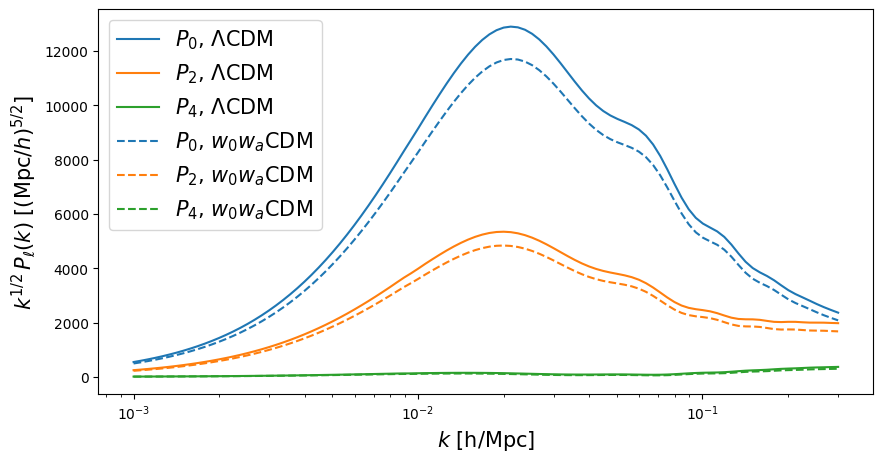

In [15]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell0"],c='C0',ls='-',label='$P_0$, $\Lambda$CDM')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell2"],c='C1',ls='-',label='$P_2$, $\Lambda$CDM')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell4"],c='C2',ls='-',label='$P_4$, $\Lambda$CDM')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_w0wa["ell0"],c='C0',ls='--',label='$P_0$, $w_0 w_a$CDM')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_w0wa["ell2"],c='C1',ls='--',label='$P_2$, $w_0 w_a$CDM')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_w0wa["ell4"],c='C2',ls='--',label='$P_4$, $w_0 w_a$CDM')
ax.set_xlabel('$k$ [h/Mpc]',fontsize=15)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{5/2}$]',fontsize=15)
ax.legend(fontsize=15)
plt.show()

## The $f$-$\sigma_{12}$ parameter space

When calling the `Pell` function for a specific dark energy model, it ignores any potential values of `s12`, `q_tr`, `q_lo` and `f` in the parameter dictionary and instead converts the $\Lambda$CDM parameters to the $\sigma_{12}$ parameter space. The internal values of those parameters (which can be accessed via `EFT.params`) have therefore been updated:

In [16]:
# s12, q_tr, q_lo and f are computed internally!
EFT.params

{'wc': 0.11544,
 'wb': 0.0222191,
 'ns': 0.9632,
 's12': array([0.56448159]),
 'f': 0.7025465611424653,
 'b1': 2.0,
 'b2': -0.5,
 'g2': 0.0,
 'g21': 0.0,
 'c0': 0.0,
 'c2': 0.0,
 'c4': 0.0,
 'cnlo': 0.0,
 'cnloB': 0.0,
 'NP0': 0.0,
 'NP20': 0.0,
 'NP22': 0.0,
 'NB0': 0.0,
 'MB0': 0.0,
 'cB1': 0.0,
 'cB2': 0.0,
 'h': 0.8,
 'As': 2.3,
 'Ok': 0.05,
 'w0': -1.1,
 'wa': 0.1,
 'z': 0.6,
 'q_tr': 1.081799699202137,
 'q_lo': 1.045999542223697}

If we want to use the $f$-$\sigma_{12}$ parameter space directly, we need to provide explicit values for `s12`, `f`, `q_lo` ($q_{\parallel}$) and `q_tr` ($q_{\perp}$). As an example, let's redefine our parameter values:

In [17]:
# For predictions using the RSD parameter space we also need to specify values for the following four parameters, e.g.
params['s12']  = 0.6
params['q_lo'] = 1.1
params['q_tr'] = 0.9
params['f']    = 0.7

_Note: When computing the multipoles using the $\sigma_{12}$ parameter space and in $h^{-1}\mathrm{Mpc}$ units, we need to specify a fiducial value for the Hubble rate (provided in the parameter dictionary). This is required to convert the native emulator output from Mpc to Mpc/h units._

In [18]:
Pell_s12 = EFT.Pell(k_hMpc, params, ell=[0,2,4])

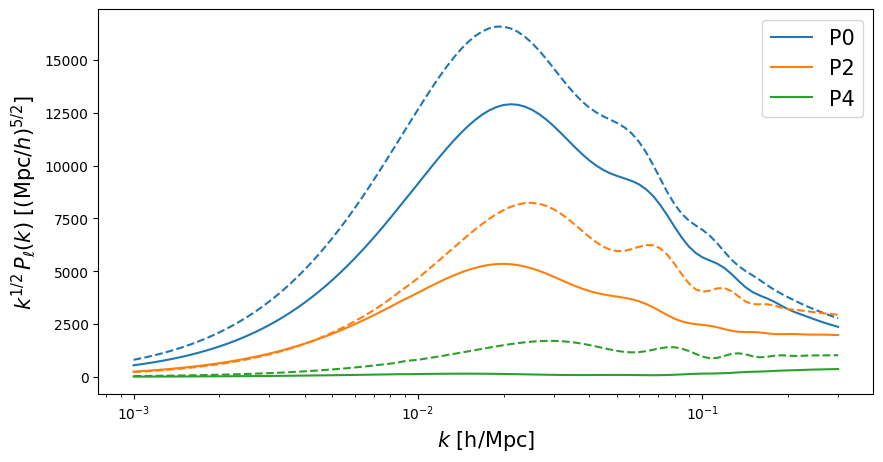

In [19]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell0"],c='C0',ls='-',label='P0')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell2"],c='C1',ls='-',label='P2')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM["ell4"],c='C2',ls='-',label='P4')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_s12["ell0"],c='C0',ls='--')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_s12["ell2"],c='C1',ls='--')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_s12["ell4"],c='C2',ls='--')
ax.set_xlabel('$k$ [h/Mpc]',fontsize=15)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{5/2}$]',fontsize=15)
ax.legend(fontsize=15)
plt.show()

## Providing different $k$-scales

There are multiple options for specifying the scales for which to compute the multipoles: if given as a number or numpy array all specified multipoles will be computed for those scales, if given as a list, however, then the first entry of the list is evaluated for the first multipole, the second for the second multipole, etc.

We can output at a single scale and single multipole number, e.g. for the quadrupole at $k = 0.1\,h\,\mathrm{Mpc}^{-1}$:

In [20]:
EFT.Pell(0.1, params, ell=2)

{'ell2': array([12734.89063923])}

Or for various multipoles and multiple scales:

In [21]:
EFT.Pell(np.array([0.1,0.2,0.3]), params, ell=[0,2,4])

{'ell0': array([21992.53270038,  8421.94731931,  5056.16492358]),
 'ell2': array([12734.89063923,  7164.45814763,  5358.95648909]),
 'ell4': array([3027.96053502, 2241.88093571, 1868.24333838])}

Or at different scales for different multipoles (providing a list of numbers or numpy arrays):

In [22]:
EFT.Pell([np.array([0.1,0.2]),0.3], params, ell=[0,4])

{'ell0': array([21992.53270038,  8421.94731931]),
 'ell4': array([1868.24333838])}

_Note: In this case, the length of the list must match the length of the specified multipoles (`ell`)._

Performance-wise it is advisable to compute all required multipoles and scales via the same function call (i.e., avoid calling `Pell` for individual wavemodes).

## Speedup when changing just bias parameters.

It is a common task to test the models at fixed cosmological parameters, and in that case COMET provides the function `Pell_fixed_cosmo_boost`, which accelerates the model computation. It computes all individual model contributions, which are kept fixed as long as the cosmological parameters are not changed, such that changing the bias parameters only is sped up drastically. In the following cells the diferences on time can be seen, which reflects a speed up of around 3 orders of magnitude.

In [25]:
%timeit EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model="lambda")

5.17 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit EFT.Pell_fixed_cosmo_boost(k_hMpc, params, ell=[0,2,4], de_model="lambda")

9.45 µs ± 23.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


_Note: Since the computation of all the individual contributions takes more time than the direct evaluation of the multipoles, this is really only useful at fixed cosmological parameters._

## Using different bases for galaxy bias

By default COMET uses the galaxy bias expansion proposed in Eggemeier et al. (2019), but it is also possible to specify bias parameters of two other bases from:
  * Assassi et al. (2014), used e.g. in the analysis by Ivanov et al. (2019)
  * d'Amico et al. (2019)
  
The bias basis is defined at initialisation using the argument `bias_basis`, which can take the strings `"EggScoSmi"` (for the Eggemeier et al. basis), `"AssBauGre"` (for the Assassi et al. basis), or `"AmiGleKok"` (for the D'Amico et al. basis). It is also possible to change the bias basis later via the function `change_bias_basis`, e.g.:

In [23]:
EFT.change_bias_basis("AssBauGre")

Changing the bias basis changes the parameter dictionary keys that need to be provided. The full list of available bias keys can be printed as follows:

In [24]:
print(EFT.bias_params_list)

['b1', 'b2', 'bG2', 'bGam3', 'c0', 'c2', 'c4', 'cnlo', 'NP0', 'NP20', 'NP22', 'NB0', 'MB0']


In this case we now need to provide values for `'bG2'` and `'bGam3'`, i.e., parameters for `'g2'` and `'g21'` are now ignored. In case of the d'Amico et al. basis we have:

In [25]:
EFT.change_bias_basis("AmiGleKok")
print(EFT.bias_params_list)

['b1t', 'b2t', 'b3t', 'b4t', 'c0', 'c2', 'c4', 'cnlo', 'NP0', 'NP20', 'NP22', 'NB0', 'MB0']


Let's change back to the default for the remainder of the tutorial:

In [26]:
EFT.change_bias_basis("EggScoSmi")

# Binning and discreteness effects

## Power spectrum

Power spectrum multipoles are estimated in Fourier space from discrete grids of wave vectors, which means that a given multipole at scale $k$ is an average over the discrete set of wave vectors $\mathbf{q}$ whose magnitude falls into the spherical shell defined by $k - \Delta k/2 \leq |\mathbf{q}| \leq k + \Delta k/2$. This leads to differences from the theory predictions, which (per default) assume continuous wave vectors and infinitesimally thin shells ($\Delta k \to 0$). However, the discreteness and finite bin width effects can be accounted for by averaging the anisotropic theory power spectrum over the same set of modes as those that are averaged over when performing the measurements.

In COMET this can be done by specifying a binning dictionary, when calling `Pell` or `Pell_fixed_cosmo_boost`. In order to compute the set of discrete modes, it is necessary to know the size (i.e., the fundamental frequency) of the Fourier grid used for the measurements, as well as the bin width. These can be specified via the keys `'kfun'` and `'dk'` in the binning dictionary. For example:

In [23]:
binning = {'kfun':0.005, 'dk':0.005}

k = 0.005 + np.arange(80)*0.005
Pell_discrete = EFT.Pell(k, params, [0,2,4], 'lambda', binning=binning)

Note: when calling `Pell` with the binning dictionary, the wavemodes specified via the argument `k` are assumed to be the bin centres.

Hint: calling `Pell` for the first time with the binning dictionary takes a while longer as COMET has to find the set of discrete modes first. Subsequent calls (provided that the binning options or the maximum bin centre have not been changed) are much faster.

A common approximation to account for the finite bin width is to evaluate the power spectrum multipoles at the so-called effective wave modes, which are weighted averages over the discrete modes in a given bin. If one wants to evaluate the power spectrum multipoles at those effective modes, one can specify the additional key `'effective':True` (`False` by default) in the binning dictionary; the wave modes specified via `k` are still supposed to correspond to the bin centres also in this case.

In [24]:
Pell_discrete_eff = EFT.Pell(k, params, [0,2,4], 'lambda', 
                             binning={'kfun':0.005, 'dk':0.005, 'effective':True})

Let's compare the two sets of predictions:

Text(0, 0.5, '$k\\,P_{\\ell}(k)$ [$(h/\\mathrm{Mpc})^2$]')

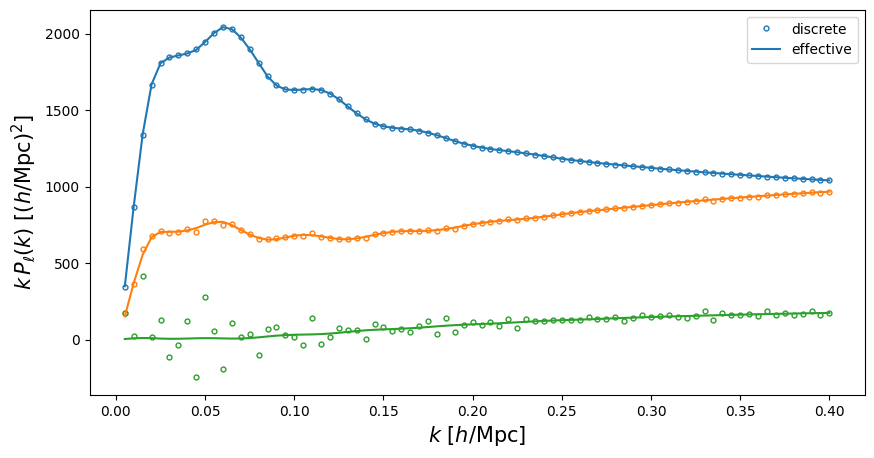

In [25]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)

ax.plot(k, k*Pell_discrete['ell0'], 'o', c='C0', mfc='none', ms=3.5, label='discrete')
ax.plot(k, k*Pell_discrete['ell2'], 'o', c='C1', mfc='none', ms=3.5)
ax.plot(k, k*Pell_discrete['ell4'], 'o', c='C2', mfc='none', ms=3.5)

ax.plot(k, k*Pell_discrete_eff['ell0'], c='C0', label='effective')
ax.plot(k, k*Pell_discrete_eff['ell2'], c='C1')
ax.plot(k, k*Pell_discrete_eff['ell4'], c='C2')

ax.legend()
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]',fontsize=15)
ax.set_ylabel('$k\,P_{\ell}(k)$ [$(h/\mathrm{Mpc})^2$]',fontsize=15)

## Bispectrum

COMET also provides the possibility to correct for binning and discreteness effects in the bispectrum, using the approximation introduced in Eggemeier et al. 2025. Like for the power spectrum, the user can call the Bell function with a binning dictionary. However, there are a number of additional options available, which are summarised below:

In [26]:
binning = {
   'kfun':0.0025,                 # fundamental frequency of Fourier grid
   'dk':0.005,                    # bin width
   'first_bin_centre':0.0025,     # k-mode of first bin centre
   'do_rounding':False,           # apply rounding to fundamental configurations: True(default)/False
   'decimals':[3,3],              # defines rounding precision, default: [3,3]
   'shape_limits':[0.999,2.001],  # defines for which triangle configurations the binning/discreteness corrections are computed, default: [0.999,1.15]
   'fiducial_cosmology':{         # defines for which fiducial cosmology the corrections are computed, default: Planck2018 + redshift in parameter dictionary
      'h': 0.7, 'wc': 0.12,
      'wb': 0.022, 'ns': 0.96,
      'As': 2.2, 'w0': -1.0,
      'wa': 0.0, 'z': 0.5
   },
   'filename_root_kernels':'test' # filename root to store binned tables
}

With the settings above, it is possible to define the triangle configurations for which the binning and discreteness corrections are being computed, as well as the efficiency (at the expense of accuracy). The `'shape_limits'` property allows the user to specify a tuple of numbers `[a,b]`, which select the following triangle configurations:
$$
\frac{k_2+k_3}{k_1} < b \quad \land \quad \frac{k_2+k_3}{k_1} > a
$$
In the following example with `binning['shape_limits'] = [0.999,1.15]` this corresponds to all triangle configurations between the two orange lines, i.e., triangle configurations that are closer to being equilateral (top right corner) are not considered for the binning correction. If one intends to compute the binning and discreteness corrections for all triangle configurations instead, one should set `binning['shape_limits'] = [0.999,2.001]`.

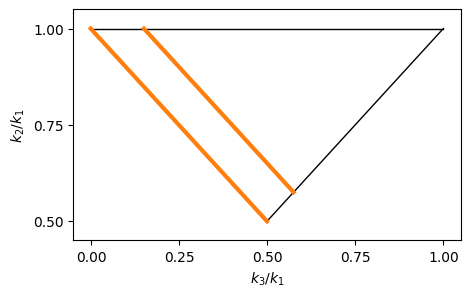

In [27]:
f = plt.figure(figsize=(5,3))
ax = f.add_subplot(111)

x1 = np.linspace(0,0.5)
x2 = np.linspace(0.5,1)

ax.set_xticks(np.linspace(0,1,5))
ax.set_xlabel(r'$k_3/k_1$')
ax.set_xticklabels(['0.00','0.25','0.50','0.75','1.00'])
ax.set_yticks(np.linspace(0.5,1,3))
ax.set_ylabel(r'$k_2/k_1$')
ax.plot(x1,1.-x1,c='k',lw=1)
ax.plot(x2,x2,c='k',lw=1)
ax.plot(np.concatenate((x1,x2)),np.ones(100),c='k',lw=1)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0.45,1.05)

shape_limits = [0.999, 1.15]
x3 = np.linspace(shape_limits[1]-1,shape_limits[1]/2)
x4 = np.linspace(shape_limits[0]-1,shape_limits[0]/2)
ax.plot(x3,shape_limits[1]-x3,c='C1',lw=3)
ax.plot(x4,shape_limits[0]-x4,c='C1',lw=3)

The properties `'do_rounding'` in combination with `'decimals'` can be used to reduce the number of fundamental triangles over which the theory predictions have to be averaged in order to improve efficiency. For `binning['decimals'] = [d1, d2]` $k_1,\,k_2,\,k_3$ and $\mu_1,\,\mu_2,\,\mu_3$ values are approximated as follows:
$$
   k_i \approx \left\lfloor 10^{d_1}\,\frac{k_i}{\Delta k} \right\rceil \, 10^{-d_1}\,\Delta k \newline
   \mu_i \approx \left\lfloor 10^{d_2}\,\mu_i \right\rceil \, 10^{-d_2}
$$

The COMET binning module constructs the list of triangle configurations based on the first bin centre, the binwdith (both given in the binning dictionary), and the maximum k-mode given in the `tri` array when calling `Bell`. Currently, it assumes that the bin centres strictly form a closed triangle, i.e. $k_1 \leq k_2 + k_3$ for $k_1 \geq k_2 \geq k_3$.

Depending on the number of triangle configurations, the identification of the fundamental triangles and the averaging of the bispectrum kernel functions can be computationally demanding. However, for a given fundamental frequency, bin width and maximum k-mode, this only has to be performed once, such that the subsequent evaluation of the bispectrum model is very fast. For that reason, COMET allows to store any required information, such that at any later time (e.g., after re-initialising COMET), the computationally demanding steps can be skipped. By specifying the property `filename_root_kernels` one can set the root for the files that are generated, and when calling `Bell` again with the same binning dictionary, COMET will try to look for any existing files.

This only works if *all* properties of the binning dictionary are **identical**.

Let's compare the bispectrum with and without the binning and discreteness corrections:

In [28]:
# define triangle configurations
k_hMpc_lin = np.arange(binning['first_bin_centre'], 0.05, binning['dk'])
tri =[]
for i1,k1 in enumerate(k_hMpc_lin):
    for i2,k2 in enumerate(k_hMpc_lin[:i1+1]):
        for i3,k3 in enumerate(k_hMpc_lin[:i2+1]):
            if i2 + i3 >= i1 - binning['first_bin_centre']/binning['dk']:
                tri.append([k1, k2, k3])
tri=np.asarray(tri)

# let's evalaute with the parameters used in the fiducial cosmology
for p in binning['fiducial_cosmology']:
    params[p] = binning['fiducial_cosmology'][p]

# evaluate bispectrum at the bin centres
Bell = EFT.Bell(tri, params, [0,2], 'lambda', kfun=binning['kfun'])

# evaluate bispectrum at the bin centres including the binning and discreteness corrections (this may take a few minutes)
Bell_discrete = EFT.Bell(tri, params, [0,2], 'lambda', kfun=binning['kfun'], binning=binning)

Text(0.5, 0, 'Triangle Index')

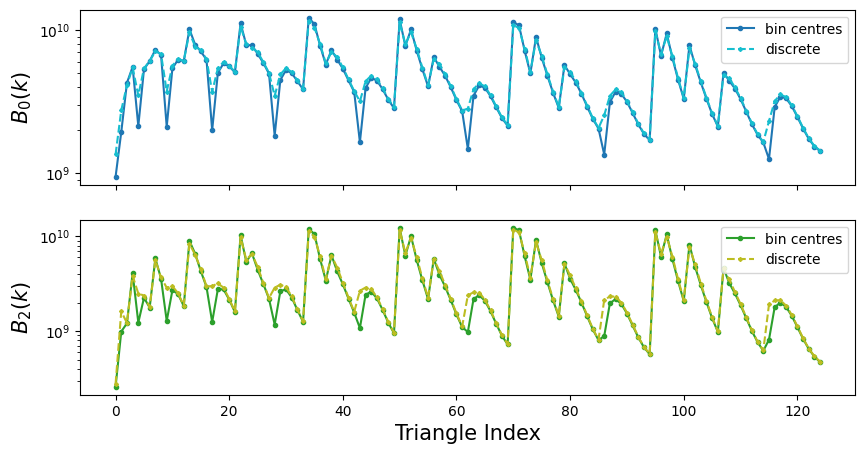

In [29]:
fig, axs = plt.subplots(2,1, figsize=(10,5), sharex=True,)
for i in range(2):
    axs[i].semilogy(np.arange(tri.shape[0]), Bell["ell"+str(2*i)],'o',c='C'+str(2*i),ls='-',ms=3,label='bin centres')
    axs[i].semilogy(np.arange(tri.shape[0]), Bell_discrete["ell"+str(2*i)],'D',c=['C9','C8'][i],ls='--',ms=2,label='discrete')
    axs[i].set_ylabel(f'$B_{i*2}(k)$',fontsize=15)
    axs[i].legend(loc=1)
axs[1].set_xlabel('Triangle Index',fontsize=15)

In [30]:
VDG = comet(model='VDG_infty', use_Mpc=False)
VDG.define_fiducial_cosmology(params_fid=params_fid)

In [31]:
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator

# extend the range of triangle configurations to see an effect of the damping
k_hMpc_lin = np.arange(binning['first_bin_centre'], 0.14, binning['dk'])
tri =[]
for i1,k1 in enumerate(k_hMpc_lin):
    for i2,k2 in enumerate(k_hMpc_lin[:i1+1]):
        for i3,k3 in enumerate(k_hMpc_lin[:i2+1]):
            if i2 + i3 >= i1 - binning['first_bin_centre']/binning['dk']:
                tri.append([k1, k2, k3])
tri=np.asarray(tri)

# generate some realistic bispectrum covariance matrix
Bell_cov = EFT.Bell_covariance(tri, params, [0,2], dk=binning['dk'], de_model='lambda', 
                               kfun=binning['kfun'], volume=3e9)

def compute_sv_avir_mapping(EFT, VDG, tri, params_fid, kf, cov_matrix, 
                            navirB, nsv, sv_min=2, sv_max=10):
    """
       This function fits the bispectrum multipoles (monopole and quadrupole) from an 
       expansion of the damping function to predictions that originate from the exact 
       damping function for a range of 'avirB' and 'sv' values.
       
       Parameters
       ----------
       EFT: PTEmu object
          Comet instance of the EFT model (with default bispectrum counterterm prescription)
       VDG: PTEmu object
          Comet instance of the VDG_infty model
       tri: numpy.array
          Array of triangle configurations
       params_fid: dictionary
          Fiducial cosmological parameters (and linear bias) to use for the calibration
       kf: float
          Fundamental frequency
       cov_matrix: numpy.array
          Covariance matrix for the bispectrum multipoles
       navirB: integer
          Number of bins in 'avirB'
       nsv: integer
          Number of bins in 'sv'
       sv_min: float
          Minimum 'sv' value
       sv_max: float
          Maximum 'sv' value
          
       Returns
       -------
       avirB_list: numpy.array
          List of covered 'avirB' values
       sv_list: numpy.array
          List of covered 'sv' values
       mapping: numpy.array
          Corresponding coefficients for the mapping to 'cnloB'
    """
    def Bapprox(tri, a):
        params['cnloB'] = -a*VDG.params['avirB']**1.75 - 0.5*VDG.params['sv']**1.75
        B = EFT.Bell(tri, params, ell=[0,2], de_model='lambda', kfun=kf)
        return np.hstack([B[m] for m in B.keys()])
    
    params = {}
    for p in ['wc','wb','ns','h','As','z']:
        params[p] = params_fid[p]
    params['b1'] = params_fid['b1']
    
    avirB_list = np.logspace(-2,np.log10(10),navirB)
    sv_list = np.linspace(sv_min,sv_max,nsv)
    mapping = np.zeros((navirB,nsv))
    for i,avirB in enumerate(avirB_list):
        for j,sv in enumerate(sv_list):
            params['avirB'] = avirB
            VDG.params['sv'] = sv
            Bref = VDG.Bell(tri, params, [0,2], 'lambda', kfun=kf)
            Bref = np.hstack([Bref[m] for m in Bref])
            popt, pcov = curve_fit(Bapprox, tri, Bref, sigma=cov_matrix)
            mapping[i,j] = popt
    return avirB_list, sv_list, mapping

# this may take a few minutes
avirB_list, sv_list, mapping = compute_sv_avir_mapping(EFT, VDG, tri, params, binning['kfun'], Bell_cov, 10, 10)

Text(0.5, 0, 'sv')

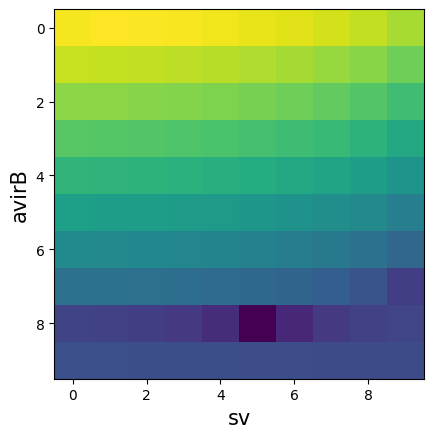

In [34]:
plt.imshow((np.log(np.abs(mapping))))
plt.ylabel('avirB',fontsize=15)
plt.xlabel('sv',fontsize=15)

In [36]:
cnloB_spline = RegularGridInterpolator((avirB_list,sv_list), mapping)

# Going back to the smaller triangle configuration grid
k_hMpc_lin = np.arange(binning['first_bin_centre'], 0.05, binning['dk'])
tri =[]
for i1,k1 in enumerate(k_hMpc_lin):
    for i2,k2 in enumerate(k_hMpc_lin[:i1+1]):
        for i3,k3 in enumerate(k_hMpc_lin[:i2+1]):
            if i2 + i3 >= i1 - binning['first_bin_centre']/binning['dk']:
                tri.append([k1, k2, k3])
tri=np.asarray(tri)

for p in binning['fiducial_cosmology']:
    params[p] = binning['fiducial_cosmology'][p]
params['avirB'] = 4

VDG.params['wc'] = 0.1 # to trigger re-evaluation of the emulators in the call below (so that the 'sv' value is updated)
Bell_VDG = VDG.Bell(tri, params, [0,2], 'lambda', kfun=binning['kfun'])

binning['filename_root_kernels'] = 'test_VDG' # need to use a different filename root
Bell_VDG_discrete = VDG.Bell(tri, params, [0,2], 'lambda', kfun=binning['kfun'], 
                             binning=binning, cnloB_mapping=cnloB_spline)

Text(0.5, 0, 'Triangle Index')

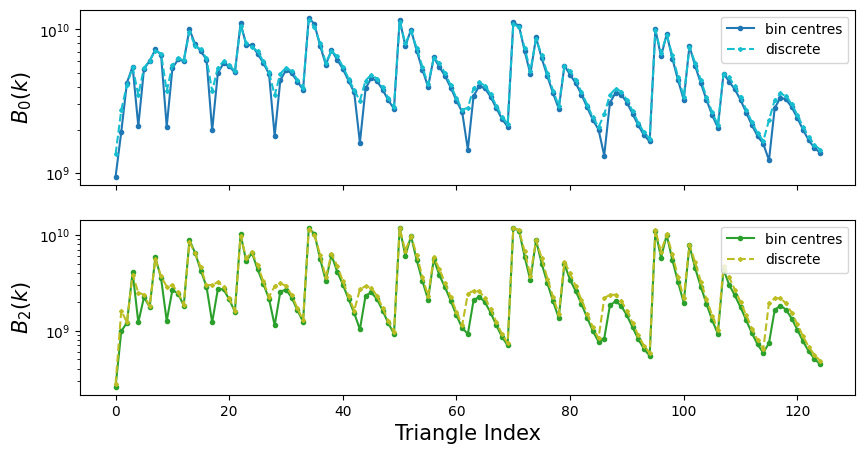

In [38]:
fig, axs = plt.subplots(2,1, figsize=(10,5), sharex=True,)
for i in range(2):
    axs[i].semilogy(np.arange(tri.shape[0]), Bell_VDG["ell"+str(2*i)],'o',c='C'+str(2*i),ls='-',ms=3,label='bin centres')
    axs[i].semilogy(np.arange(tri.shape[0]), Bell_VDG_discrete["ell"+str(2*i)],'D',c=['C9','C8'][i],ls='--',ms=2,label='discrete')
    axs[i].set_ylabel(f'$B_{i*2}(k)$',fontsize=15)
    axs[i].legend(loc=1)
axs[1].set_xlabel('Triangle Index',fontsize=15)

In [79]:
mu_true = 0.5
mu_biased = 3.5
sig_true = 1.0
diff = mu_biased-mu_true
sig_biased = np.sqrt(sig_true**2+diff**2)

samples_true = np.random.normal(loc=mu_true, scale=sig_true, size=50000)
samples_biased = np.random.normal(loc=mu_biased, scale=sig_biased, size=50000)

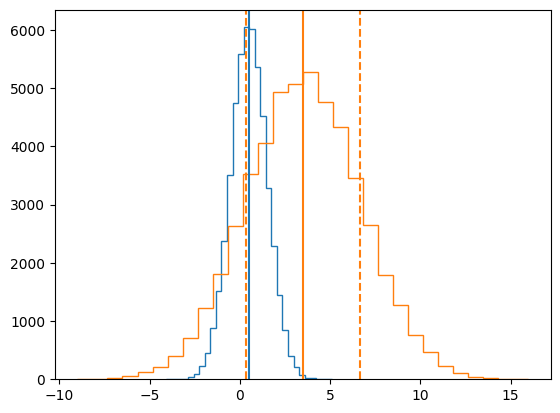

In [80]:
plt.hist(samples_true,30,histtype='step')
plt.hist(samples_biased,30,histtype='step')
plt.axvline(mu_true,color='C0')
plt.axvline(mu_biased,color='C1')
plt.axvline(mu_biased-sig_biased,color='C1',ls='--')
plt.axvline(mu_biased+sig_biased,color='C1',ls='--')

In [59]:
diff = samples_biased-samples_true

diff_avg = np.average(diff)
diff_std = np.std(diff)

In [60]:
diff_avg

0.20243925832785903

In [64]:
1/(1+0.2/0.5)**2

0.5102040816326532

In [61]:
diff_std**2

1.9720079321704735

# Beyond $P_{\ell}$ predictions

In the following we demonstrate a number of additional outputs that COMET can provide. Specifically:
  * The linear power spectrum, with and without infra-red resummation
  * The Gaussian covariance matrix for the power spectrum multipoles
  * The tree-level bispectrum multipoles

## Linear power spectrum

The linear power spectrum (no infra-red resummation; simply the emulated CAMB output) can be obtained from the function `PL`, while the linear power spectrum with damped BAO wiggles (infra-red resummation) can be obtained from the function `Pdw` (note: this is not the smooth, no-wiggle power spectrum). The arguments are identical to those of `Pell` with the exception that we no longer need to specify a multipole number. 

In [31]:
k = np.logspace(-3,np.log10(0.4),300)
Pdw = EFT.Pdw(params=params, k=k, de_model='lambda')
PL = EFT.PL(params=params, k=k, de_model='lambda')

Let's plot the ratio of the de-wiggled linear power spectrum over the linear power spectrum:

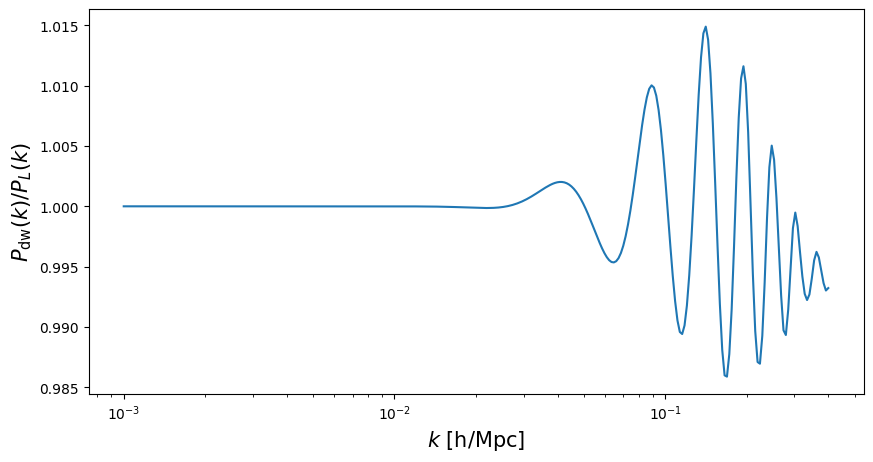

In [32]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.semilogx(k, Pdw/PL,c='C0',ls='-')
ax.set_xlabel('$k$ [h/Mpc]',fontsize=15)
ax.set_ylabel(r'$P_{\rm dw}(k)/P_{L}(k)$',fontsize=15)
plt.show()

## Tree-level bispectrum

COMET can also output the tree-level bispectrum (in real-space, for the `RS` model) and its multipoles (in redshift-space, for the `EFT` model). These predictions are not emulated, but computed from the emulated de-wiggled power spectrum directly. For that purpose we provide the function `Bell` and in order to demonstrate its usage let's first generate a set of triangle configurations:

In [33]:
k_hMpc_lin = np.arange(0.005, 0.3, 0.005)
tri =[]
for i1,k1 in enumerate(k_hMpc_lin):
    for i2,k2 in enumerate(k_hMpc_lin[:i1+1]):
        for i3,k3 in enumerate(k_hMpc_lin[:i2+1]):
            if k2 + k3 >= k1:
                tri.append([k1, k2, k3])
tri=np.asarray(tri)

The `Bell` function has the same arguments and functionality as the analogous `Pell` function for the power spectrum. However, it expects the triangle configurations to be always specified as a numpy array containing $k_1$, $k_2$, $k_3$ (it is not possible to evaluate the multipoles for different triangles at the moment), and in addition it includes the argument `kfun`, which is used for compressing the number of unique k-modes and is ideally chosen as a value that corresponds closely to the spacing between configurations (e.g. the bin-width for measured data), but must not be much larger. If in doubt, use a value much smaller than the typical spacing. 

In [34]:
params['h'] = 0.69
params['z'] = 0.57
Bell = EFT.Bell(tri, params=params, ell=[0,2,4], de_model='lambda', kfun=0.005)

_Note: The very first call of `Bell` for a given set of configurations can take a little longer (depending on the total number of triangle configurations) as some lookup-tables are generated. All subsequent calls, even with changing cosmological parameters, are then much faster. That implicitly means that one should avoid calling `Bell` multiple times with different triangle configurations, but once for all triangle configurations._

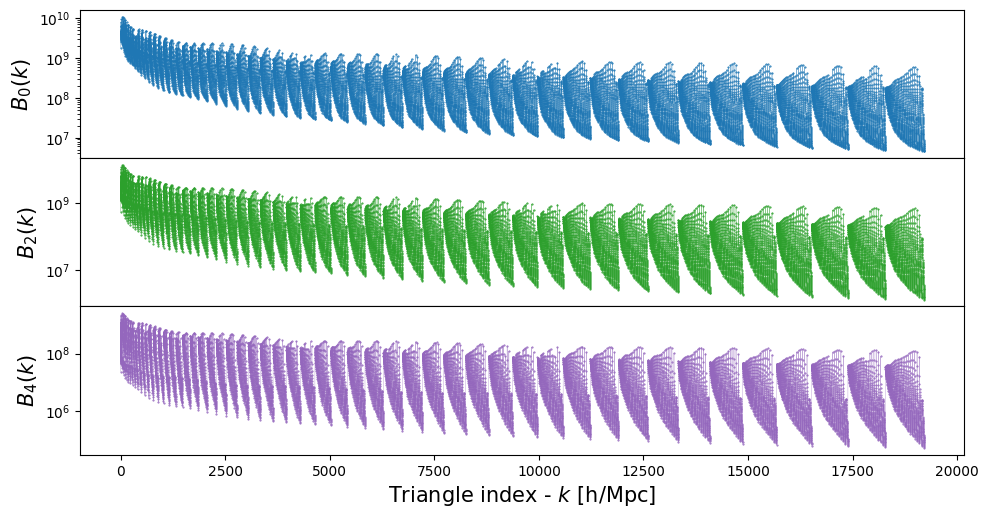

In [35]:
fig, axs = plt.subplots(3,1, figsize=(10,5), sharex=True,)
for i in range(3):
    axs[i].semilogy(np.arange(tri.shape[0]), Bell["ell"+str(2*i)],'.',c='C'+str(2*i),ls='-',ms=1,lw=0.2)
    axs[i].set_ylabel(f'$B_{i*2}(k)$',fontsize=15)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
axs[-1].set_xlabel('Triangle index - $k$ [h/Mpc]',fontsize=15)
plt.show()

## Computing covariance matrices

Apart from the multipoles we can also generate (Gaussian) covariance matrices, for which there are again different flags, that are either defined for the $\sigma_{12}$ or the dark energy parameter spaces. For the power spectrum, the first three arguments, `k`, `params`, and `ell`, are identical to those for `Pell`. In addition, we need to specify a binwidth `dk` and volume (both of which need to be given in the respective units for which the emulator is configured in), for example:

In [36]:
dk_hMpc = 0.005
k_hMpc_lin = np.arange(0.001, 0.3, dk_hMpc)
vol_hMpc = 3e9

In [37]:
Cov_hMpc = EFT.Pell_covariance(k_hMpc_lin, params, ell=[0,2,4], dk=dk_hMpc, volume=vol_hMpc)

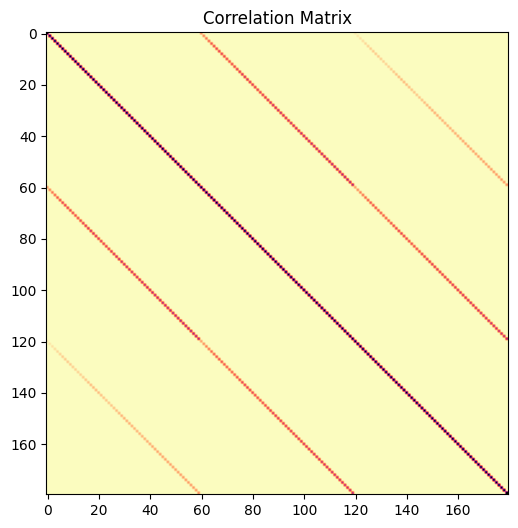

In [38]:
plt.figure(figsize=(9,6))
plt.title(r"")
plt.title(r"Correlation Matrix")
var_inv = np.diag(1./np.sqrt(np.diag(Cov_hMpc)))
R_hMpc = var_inv @ Cov_hMpc @ var_inv
plt.imshow(R_hMpc,cmap='magma_r')
plt.show()

The argument specifying the scales provides the same functionality as for `Pell`, that is, it can either be given as a number or numpy array, in which case all specified multipoles are evaluated for the same scales, or a list of numbers/numpy arrays, in which case the first entry is evaluated for the first multipole in `ell` etc.

For the version with specified dark energy model it is also possible (in addition to providing the volume via the `volume` argument) to provide minimum and maximum redshifts, `zmin` and `zmax`, a sky fraction `fsky`, and a volume scaling factor `volfac` (by default equal to 1), such that the volume is computed in accordance with the given cosmological model. For example:

In [39]:
Cov_hMpc_LCDM = EFT.Pell_covariance(
                        k_hMpc, 
                        params, 
                        ell=[0,2,4],
                        dk=2*np.pi/3780, 
                        zmin=params['z']-0.1, 
                        zmax=params['z']+0.1, 
                        fsky=15000./(360**2/np.pi), 
                        volfac=1, 
                        de_model="lambda", 
                )

As a further extension, in the case when using measurements from a periodic box that have been averaged over different lines of sight, we have added the averaging corrections for the covariance matrix. We have created the flags `avg_cov` (set to `False` by default) and `avg_los` (set to 3 by default) for the `Pell_covariance` function, so that when `avg_cov=True` it by default will compute the average along the three perpendicular axes (x,y,z), but it is also possible to average over just 2 directions. Note that this computation is quite slow since it involves a different  integral for each k-bin, it may be optimised in the future.

Similarly, we can compute the Gaussian covariance matrix of the bispectrum using the function `Bell_covariance`. Apart from the first argument, which specifies the triangle configurations (or a list of configurations for different multipoles), the arguments are identical to those of `Pell_covariance`. In addition, one can also specify `kfun` as in case of `Bell` (see above), which by default is set to the bin width `dk`. Let us compute the bispectrum covariance matrix for a reduced set of triangle configurations with different scale cuts for the monopole, quadrupole, and hexadecapole:

In [40]:
id0p1 = np.where(tri[:,0] < 0.1)
id0p06 = np.where(tri[:,0] < 0.06)
id0p03 = np.where(tri[:,0] < 0.03)

# using the same scale cut for all multipoles
Cov_Bisp_hMpc = EFT.Bell_covariance(tri[id0p1], params, ell=[0,2,4], dk=0.005, de_model='lambda',
                                    kfun=0.005, volume=3e9)

# using different scale cuts
Cov_Bisp_hMpc_diff_scale_cut = EFT.Bell_covariance([tri[id0p1],tri[id0p06],tri[id0p03]], params, ell=[0,2,4], 
                                                   dk=0.005, de_model='lambda', kfun=0.005, volume=3e9)

In the Gaussian approximation each block in the bispectrum covariance matrix is diagonal. Let's plot these diagonals as a function of the triangle configuration index:

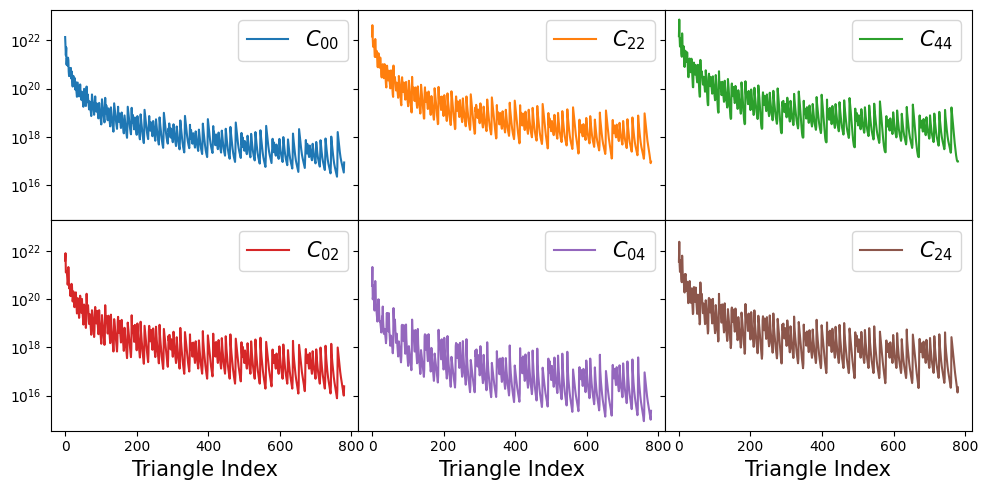

In [41]:
fig, axs = plt.subplots(2,3, figsize=(10,5), sharex=True, sharey=True)

ntri = id0p1[0].shape[0]

labels = ['$C_{00}$', '$C_{22}$', '$C_{44}$', '$C_{02}$', '$C_{04}$', '$C_{24}$']
colors = ['C0','C1','C2','C3','C4','C5']
for i in range(3):
    axs[0,i].semilogy(np.arange(ntri), np.diag(Cov_Bisp_hMpc[i*ntri:(i+1)*ntri,i*ntri:(i+1)*ntri]), c=colors[i], label=labels[i])
    axs[0,i].legend(fontsize=15)
    
n = 0
for i in range(2):
    for j in range(i,3):
        if i != j:
            axs[1,n].semilogy(np.arange(ntri), np.diag(Cov_Bisp_hMpc[i*ntri:(i+1)*ntri,j*ntri:(j+1)*ntri]), c=colors[n+3], label=labels[n+3])
            axs[1,n].legend(fontsize=15)
            axs[1,n].set_xlabel('Triangle Index',fontsize=15)
            n += 1

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

Note that both, `Pell_covariance` and `Bell_covariance`, allow also to specify the number of fundamental modes and fundamental triangle per bin, respectively. This is possible by using the optional arguments `Nmodes` and `Ntri`, which should be an array of the same length as either `k` or `tri` (and if either of these is given as a list, it should match the length of the longest entry in the list of scales or triangle configurations). If not provided, the following approximations are assumed when computing the covariance matrix:
$$
N_{\rm modes} \approx \frac{V}{6 \pi^2}\,\left[\left(k+\frac{\Delta k}{2}\right)^3 - \left(k-\frac{\Delta k}{2}\right)^3\right]\,, \\[1.5em]
N_{\rm tri} \approx \frac{V^2}{8 \pi^4}\,k_1\,k_2\,k_3\,\Delta k^3\,.
$$

# Working with data sets

## Loading data

We can load measurements of the power spectrum and bispectrum multipoles into COMET using the `define_data_set` function. This function takes first an identifier for the data set (`obs_id`; this can be anything, it will be used to reference the data) and any one of the following arguments:
   * `stat`. Can either be `'powerspectrum'` or `'bispectrum'`; if not provided, `stat` is deduced from the number of columns in `bins` (see below).
   * `bins`. In case of the power spectrum: 1d-array of k-modes corresponding to the measurements; in case of the bispectrum: 2d-array with three columns corresponding to the triangle configuration ($k_1$, $k_2$, $k_3$) of the measurements.
   * `signal`. The measurements of the power spectrum or bispectrum; the size of the first dimension must match the size of `bins`, and it is assumed that the first column corresponds to the monopole, the second to the quadrupole, and the third to the hexadecapole (one does not need to provide all three multipoles, i.e., one can provide only the monopole, or monopole + quadrupole, but one cannot leave out preceding multipoles).
   * `cov`. The covariance matrix of the measurements, which must match the combined size of all given multipoles. If the dimension of `cov` is one-dimensional, it is assumed to be the diagonal of the covariance matrix.
   * `theory_cov`. A flag that specifies whether the given covariance matrix was derived analytically or from a set of simulation measurements. In the latter case an Anderson-Hartlap correction is applied to the inverse, based on `n_realizations`.
   * `n_realizations`. Number of realizations from which the covariance matrix was estimated, only used (and required) in case `theory_cov=False`.

Let us load some mock power spectrum measurements:

In [26]:
data = np.loadtxt('mock_Pk_mean.dat')
Cov = np.loadtxt('mock_Pk_cov.dat')

k = data[:,0]
P0 = data[:,1]
P2 = data[:,3]
P4 = data[:,5]

In [27]:
# Let's call this data set 'mock_Pk'
EFT.define_data_set(obs_id='mock_Pk', bins=k, signal=np.array([P0,P2,P4]).T, cov=Cov, theory_cov=False, n_realizations=300)

We can access the data through `EFT.data['mock_Pk']` and check, for example, that the type of statistic was correctly identified (since it was provided above):

In [28]:
EFT.data['mock_Pk'].stat

'powerspectrum'

## Computing the $\chi^2$

Finally, we can let COMET directly compute $\chi^2$ values based on the provided data set, a given set of model parameters and range of scales. 

To do so, we call the function `chi2`, which takes as arguments the identifier of the data set, the parameter dictionary, a maximum k-mode value `kmax`, a model argument `de_model`. `kmax` can either be a number, in which case the same cutoff is applied for all multipoles, or a list of numbers for each individual multipole, as for the multipoles case. If the cutoff is zero (or smaller than the minimum scale of the observations) for a particular multipole, then it is excluded from the computation of the chi-square. `kmax` is also assumed to be in the units of the emulator. `de_model` can be one of the options specified before. 

In [29]:
EFT.chi2(obs_id='mock_Pk',params=params, kmax=[0.30, 0.30, 0.30], de_model='lambda', convolve_window=False)

6754.176546673202

Moreover, in order to speed up the computation of the $\chi^2$, in the same way as `Pell_fixed_cosmo_boost` function, we can specify the flag `chi2_decomposition` in order to avoid recomputing the quantities depending on cosmological parameters. Let's see how it works

In [117]:
%timeit EFT.chi2(obs_id='mock_Pk',params=params, kmax=[0.30, 0.30, 0.30], de_model='lambda', chi2_decomposition=False)

6.37 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
%timeit EFT.chi2(obs_id='mock_Pk',params=params, kmax=[0.30, 0.30, 0.30], de_model='lambda', chi2_decomposition=True)

9.11 µs ± 20.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


It is also possible to compute the $\chi^2$ for multiple data sets by giving `chi2` a list of data identifiers. While in principle this could be useful to simultaneously analyse multiple power spectrum measurements at different redshifts, COMET currently does not support multiple parameter sets with different bias parameters, or at various redshifts (this will be possible in a future release). However, we can use this functionality to compute the joint $\chi^2$ of the power spectrum and bispectrum. 

As an example, let's load some mock bispectrum data and store it in a new data container:

In [30]:
# data format: k1, k2, k3, B0, B0_var, B2, B2_var, B4, B4_var
data = np.loadtxt('mock_Bk_mean.dat') 

EFT.define_data_set(obs_id='mock_Bk', bins=data[:,:3], signal=data[:,[3,5,7]], cov=np.hstack(data[:,[4,6,8]]), kfun=0.00166)

When providing a list of data identifiers, the `kmax` argument passed to `chi2` can be a dictionary of $k_{\rm max}$ values, where the keys must match the data identifiers. If not given as a dictionary, the same $k_{\rm max}$ is used for each of the data sets. The following call of `chi2` evaluates the $\chi^2$ for the power spectrum and bispectrum data sets, using the power spectrum monopole and quadrupole up to $k_{\rm max} = 0.3$ and $0.25\,h\,\mathrm{Mpc}^{-1}$, respectively, and the bispectrum monopole and hexadecapole up to $k_{\rm max} = 0.12$ and $0.05\,h\mathrm{Mpc}^{-1}$:

In [31]:
EFT.chi2(['mock_Pk','mock_Bk'], params, {'mock_Pk':[0.3,0.25,0.], 'mock_Bk':[0.12,0.0,0.05]}, de_model='lambda')

65495175908.83485

Note that the option `chi2_decomposition` is currently not available for the bispectrum.

## Convolution with survey window function

In order to compare the power spectrum model predictions to some actual measurements, we need to convolve with the survey window function. This can be done within COMET by providing a window function mixing matrix $W_{\ell\ell'}(k,k')$ that connects the convolved and unconvolved power spectra via a simple matrix multiplication (see e.g. d'Amico et al. 2019):
$$
P_{W,\ell}(k) = W_{\ell\ell'}(k,k') \cdot P_{\ell'}(k')\,,
$$
where the summation over multipole numbers is implicit. 

The mixing matrix and the associated scales for which it has been computed, $k$ and $k'$, can be specified via `define_data_set` using the arguments `bins_mixing_matrix` and `W_mixing_matrix`. The former is a list, containing the arrays for $k$ and $k'$. For example:

In [30]:
# Let's load some sample window function and k_prime values
W = np.fromfile('mock_Pk_window_W.npy').reshape((216, 4854))
k_prime = np.loadtxt('mock_Pk_window_kp.dat')

# The mixing matrix was computed for the following k-scales
k = np.arange(1,73)*2*np.pi/1500

# Load everything into COMET using the same data identifier as before ('mock_Pk')
EFT.define_data_set(obs_id='mock_Pk', bins_mixing_matrix=[k, k_prime], W_mixing_matrix=W)

We can now obtain the window-convolved power spectrum by passing the additional argument `obs_id` to `Pell` (the same functionality applies also to `Pell_fixed_cosmo_boost`) using the corresponding data identifier:

In [31]:
P_unconv = EFT.Pell(k, params, ell=[0,2,4], de_model='lambda')                  # unconvolved, equivalent with obs_id=None
P_conv = EFT.Pell(k, params, ell=[0,2,4], de_model='lambda', obs_id='mock_Pk')  # convolved with window function for data set 'mock_Pk'

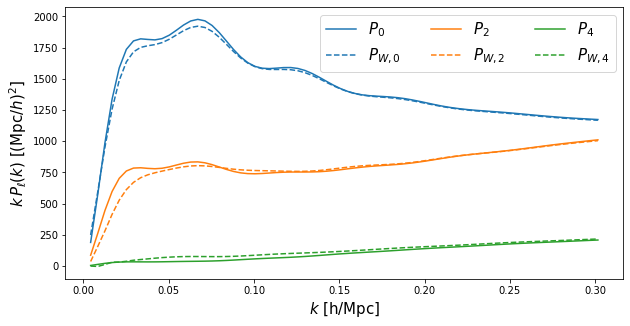

In [32]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(k, k*P_unconv['ell0'],c='C0',ls='-',label='$P_{0}$')
ax.plot(k, k*P_conv['ell0'],c='C0',ls='--',label='$P_{W,0}$')
ax.plot(k, k*P_unconv['ell2'],c='C1',ls='-',label='$P_{2}$')
ax.plot(k, k*P_conv['ell2'],c='C1',ls='--',label='$P_{W,2}$')
ax.plot(k, k*P_unconv['ell4'],c='C2',ls='-',label='$P_{4}$')
ax.plot(k, k*P_conv['ell4'],c='C2',ls='--',label='$P_{W,4}$')
ax.set_xlabel('$k$ [h/Mpc]',fontsize=15)
ax.set_ylabel(r'$k\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]',fontsize=15)
ax.legend(fontsize=15,ncol=3)

We can also take the window function convolution into account when computing the $\chi^2$. In that case we set the flag `convolve_window=True` (by default it is set to `False`):

In [33]:
EFT.chi2(obs_id='mock_Pk',params=params, kmax=[0.30, 0.30, 0.30], de_model='lambda', convolve_window=True)

6745.515807012584

This also works in combination with the option `chi2_decomposition=True`.